In [1]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import re


%matplotlib inline

import pandas_profiling # утилита, удобна для знакомства с данными
# с её помощью можно получить кучу описательных статистик по датасету

from wordcloud import WordCloud

import os

from PIL import Image

from sklearn.model_selection import train_test_split

# Кодирование категориальных переменных
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Шкалирование переменных
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Модели
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb 
import time
from sklearn.metrics import cohen_kappa_score, make_scorer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
# SGD - стохастический градиентный спуск

import sklearn
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords
import pymorphy2
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_csv("train/train.csv")

breeds = pd.read_csv('../petfinder/breed_labels.csv') # словарь пород
colors = pd.read_csv('../petfinder/color_labels.csv') # словарь окрасов шерсти
states = pd.read_csv('../petfinder/state_labels.csv') # словарь местоположения

data.shape

(14993, 24)

In [3]:
missing = data.isnull().sum().to_frame(name = "count_of_missing_values")
missing["%"] = data.isnull().sum() / len(data)
missing

,count_of_missing_values,%
Type,0,0.000000
Name,1257,0.083839
Age,0,0.000000
Breed1,0,0.000000
Breed2,0,0.000000
Gender,0,0.000000
Color1,0,0.000000
Color2,0,0.000000
Color3,0,0.000000
MaturitySize,0,0.000000


In [4]:
data["Description"].fillna('', inplace=True)

In [5]:
data = data[["Description", "AdoptionSpeed"]]

In [6]:
data["Description"] = data["Description"].apply(lambda x: x.lower())
data["Description"][0]

"nibble is a 3+ month old ball of cuteness. he is energetic and playful. i rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. the result was this little kitty. i do not have enough space and funds to care for more cats in my household. looking for responsible people to take over nibble's care."

In [7]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([re.sub("\W", "", stemmer.stem(word)) for word in text.split(' ') if word not in stop])

In [8]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def data_Lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([re.sub("\W", "", lemmatizer.lemmatize(w, get_wordnet_pos(w))) for w in nltk.word_tokenize(text) if (w not in string.punctuation and w not in stop)])

In [9]:
index = 0
print(f"Text = {data['Description'][index]} \n")
print(f"Stemming = {data_Stemmer(data['Description'][index])} \n")
print(f"Lemmatiz = {data_Lemmatizer(data['Description'][index])} \n")

Text = nibble is a 3+ month old ball of cuteness. he is energetic and playful. i rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. the result was this little kitty. i do not have enough space and funds to care for more cats in my household. looking for responsible people to take over nibble's care. 

Stemming = nibbl 3 month old ball cuteness energet playful rescu coupl cat month ago could get neuter time clinic fulli scheduled result littl kitty enough space fund care cat household look respons peopl take nibbl care 

Lemmatiz = nibble 3 month old ball cuteness energetic playful rescue couple cat month ago could get neuter time clinic fully schedule result little kitty enough space fund care cat household look responsible people take nibble s care 



In [10]:
t_start = time.time()
data_stem = data.copy()
data_stem["Description"] = data_stem["Description"].apply(lambda x: data_Stemmer(x))
data_stem["Description"][0]
t_end = time.time()
print(f"Time = {t_end - t_start} seconds")

Time = 13.74820852279663 seconds


In [11]:
t_start = time.time()
data_lem = data.copy()
data_lem["Description"] = data_lem["Description"].apply(lambda x: data_Lemmatizer(x))
data_lem["Description"][0]
t_end = time.time()
print(f"Time = {t_end - t_start} seconds")

Time = 641.3540880680084 seconds


In [12]:
X = data_stem["Description"]
y = data_stem["AdoptionSpeed"]

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.001, norm='l2')

In [14]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
X_train_tfidf = tf_vectorizer.fit_transform(X_train)
X_test_tfidf = tf_vectorizer.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape

((10495, 6015), (4498, 6015))

In [46]:
sklearn_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df=0.001)
X_train_vect = sklearn_vectorizer.fit_transform(X_train)
X_test_vect = sklearn_vectorizer.transform(X_test)
X_train_vect.shape, X_test_vect.shape

((10495, 5358), (4498, 5358))

In [47]:
X_l = data_lem["Description"]
y_l = data_lem["AdoptionSpeed"]

X_train_l, X_test_l, y_train_l, y_test_l  = train_test_split(X_l, y_l, test_size=0.30, random_state=42)

X_train_tfidf_l = tf_vectorizer.fit_transform(X_train_l)
X_test_tfidf_l = tf_vectorizer.transform(X_test_l)
X_train_tfidf_l.shape, X_test_tfidf_l.shape

((10495, 6090), (4498, 6090))

In [48]:
X_train_vect_l = sklearn_vectorizer.fit_transform(X_train_l)
X_test_vect_l = sklearn_vectorizer.transform(X_test_l)
X_train_vect_l.shape, X_test_vect_l.shape

((10495, 5282), (4498, 5282))

### baseline

In [52]:
y_naive_pred = np.random.choice(
    [4., 2., 3., 1., 0.], 
    len(y_test), 
    p=y_train.value_counts(normalize=True).values) # p - вероятности

In [53]:
print(cohen_kappa_score(y_test, y_naive_pred, weights='quadratic'))

0.010101483137738843


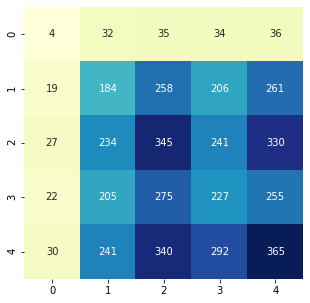

In [54]:
cm = confusion_matrix(y_test, y_naive_pred)

conf_matrix = pd.DataFrame(data = cm, index=range(0, 5), columns=range(0, 5))
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);
# внизу предсказанные метки, слева - истинные метки

Используем для обучения линейные модели с использованием регуляризации

In [55]:
logit_sgd = SGDClassifier(
    loss='log', # так как в loss указано log, то получим классическую логистическую регрессию 
    # с методом обучения стохастического градиентного спуска.
    shuffle=True, # для перемешивания выборки (перемешивает - обучается, перемешивает - обучается,...)
    n_iter_no_change=10, # критерий остановки - число итераций без изменения функции потерь
    # если последовательно в течение 10 итераций не было улучшения score, то перестает учиться
    max_iter=1000, # максимальное число итераций
    penalty='l1', # l1 - регуляризация
    random_state=42
)

SGDClassifier позволяет получить интерпретируемые оценки. Можно посмотреть наличие каких слов или словосочетаний приводит к той или иной скорости принятия питомца в семью

0.28765711913571734
0.15884389774857655


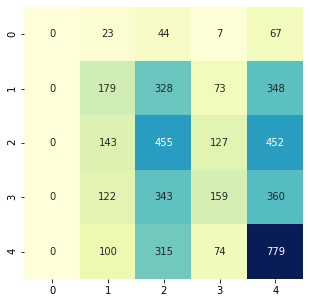

In [56]:
logit_sgd.fit(X_train_tfidf, y_train)

print(cohen_kappa_score(y_train, logit_sgd.predict(X_train_tfidf), weights='quadratic'))
print(cohen_kappa_score(y_test, logit_sgd.predict(X_test_tfidf), weights='quadratic'))

cm = confusion_matrix(y_test, logit_sgd.predict(X_test_tfidf))

conf_matrix = pd.DataFrame(data = cm, index=range(0, 5), columns=range(0, 5))
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);
# внизу предсказанные метки, слева - истинные метки

0.27392100933355734
0.1744549420826853


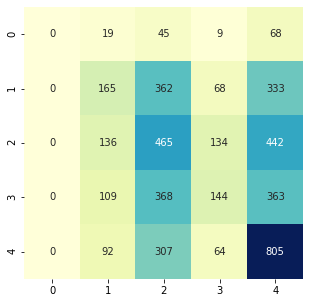

In [117]:
logit_sgd.fit(X_train_tfidf_l, y_train_l)

print(cohen_kappa_score(y_train_l, logit_sgd.predict(X_train_tfidf_l), weights='quadratic'))
print(cohen_kappa_score(y_test_l, logit_sgd.predict(X_test_tfidf_l), weights='quadratic'))

cm = confusion_matrix(y_test_l, logit_sgd.predict(X_test_tfidf_l))

conf_matrix = pd.DataFrame(data = cm, index=range(0, 5), columns=range(0, 5))
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [32]:
# функция для подбора наилучших параметров
def grid_search_cv(model, param_grid, x_train, y_train):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    kappa_scorer = make_scorer(cohen_kappa_score, weights = 'quadratic')
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring=kappa_scorer, verbose=4)
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('model {} best score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} seconds'.format(t_end - t_start))
    print(f"Best params = {grid_search.best_estimator_}")
    return grid_search.best_estimator_

In [31]:
param_grid = {
    'loss': ['log'],
    'penalty': ['l1','l2'],
    'random_state': [42],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'n_iter_no_change': [5, 10, 15],
    'class_weight': ['balanced', None],
    'eta0': [0.01, 0.1, 0.05]
}

In [58]:
sgd = grid_search_cv(SGDClassifier(), param_grid, X_train_tfidf, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.9s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.8s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.6s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.9s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.8s
[CV 7/10] END class_weight=balanced

[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.0s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.9s
[CV 7/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.1s
[CV 8/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.1s
[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.0s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.9s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_ch

[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.4s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.4s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.4s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.3s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=1

[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 7/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 8/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=lo

[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.8s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.7s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.4s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.8s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.4s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.7s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_c

[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 8/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=1

[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.5s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.5s
[CV 1/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 2/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 3/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, pena

[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 6/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 7/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 8/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.3s
[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.5s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_it

[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.9s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 1/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.6s
[CV 2/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.8s
[CV 3/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.7s
[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.7s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10,

[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=

[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.3s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.3s
[CV 1/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 2/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, pena

[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.2s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.4s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.3s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_i

[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.9s
[CV 1/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.8s
[CV 2/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.2s
[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.2s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_n

[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.4s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.3s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.5s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.6s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.4s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.5s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_ch

[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.9s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.9s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.7s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.7s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.7s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 5/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random

[CV 6/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.9s
[CV 7/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.8s
[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.4s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=

[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.8s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.8s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.8s
[CV 5/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 7/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penal

[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.5s
[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.5s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.5s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.1s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.0s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.1s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random

[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=

[CV 2/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 3/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 4/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; tota

[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 2/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.7s
[CV 3/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 4/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2,

[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.4s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.2s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.3s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.3s
[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.3s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.3s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=

[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.6s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 7/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.9s
[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_

[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 9/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 1/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.4s
[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.5s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.4s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42;

[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.9s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.8s
[CV 7/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.7s
[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.6s
[CV 9/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.6s
[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2,

[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.9s
[CV 1/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.9s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.9s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.8s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=

0.18808613133170438
Time = 0.4965803623199463 seconds


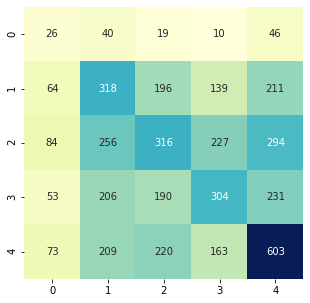

In [17]:
t_start = time.time()
sgd = SGDClassifier(class_weight='balanced', eta0=0.1, learning_rate='constant',
              loss='log', random_state=42)
sgd.fit(X_train_tfidf, y_train)
t_end = time.time()

print(cohen_kappa_score(y_test, sgd.predict(X_test_tfidf), weights='quadratic'))
print(f"Time = {t_end - t_start} seconds")

cm = confusion_matrix(y_test, sgd.predict(X_test_tfidf))

conf_matrix = pd.DataFrame(data = cm, index=range(0, 5), columns=range(0, 5))
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [120]:
sgd = grid_search_cv(SGDClassifier(), param_grid, X_train_tfidf_l, y_train_l)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.0s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.9s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.8s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.9s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.8s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.8s
[CV 7/10] END class_weight=balanced

[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.0s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 7/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.0s
[CV 8/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.9s
[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.9s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_ch

[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.3s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.3s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.4s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.3s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.4s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=1

[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 7/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 8/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=lo

[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.8s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.6s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.4s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.6s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.6s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.6s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_c

[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 7/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 8/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=1

[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.6s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.5s
[CV 1/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 2/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 3/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, pena

[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 6/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 7/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 8/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_it

[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.9s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 1/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.7s
[CV 2/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.7s
[CV 3/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.8s
[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.1s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10,

[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=

[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.3s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.3s
[CV 1/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 2/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, pena

[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.1s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_i

[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.7s
[CV 1/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.9s
[CV 2/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.0s
[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.1s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_n

[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.4s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.4s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.4s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.2s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.5s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.3s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_ch

[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.8s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.8s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.6s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.6s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.6s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.6s
[CV 5/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random

[CV 6/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.5s
[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.5s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.3s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=

[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.8s
[CV 6/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 7/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penal

[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.5s
[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.4s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.4s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.9s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.9s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.9s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random

[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=

[CV 2/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 3/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 4/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.2s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; tota

[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.7s
[CV 2/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.7s
[CV 3/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 4/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2,

[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.3s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.4s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.4s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.4s
[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.4s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.3s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=

[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.8s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.8s
[CV 7/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.8s
[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_

[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 9/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.1s
[CV 1/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.4s
[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.4s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.4s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42;

[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.7s
[CV 7/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.7s
[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.8s
[CV 9/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.7s
[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2,

[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.8s
[CV 1/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=

0.17813713494979488
Time = 0.2922213077545166 seconds


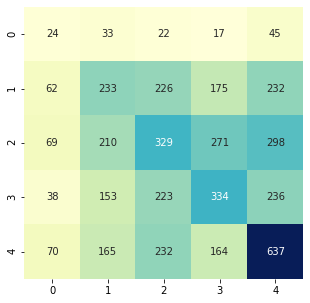

In [121]:
t_start = time.time()
sgd = SGDClassifier(class_weight='balanced', eta0=0.01, loss='log', random_state=42)
sgd.fit(X_train_tfidf_l, y_train_l)
t_end = time.time()

print(cohen_kappa_score(y_test_l, sgd.predict(X_test_tfidf_l), weights='quadratic'))
print(f"Time = {t_end - t_start} seconds")

cm = confusion_matrix(y_test_l, sgd.predict(X_test_tfidf_l))

conf_matrix = pd.DataFrame(data = cm, index=range(0, 5), columns=range(0, 5))
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [49]:
sgd = grid_search_cv(SGDClassifier(), param_grid, X_train_vect, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.7s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.6s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.0s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.8s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.8s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.7s
[CV 7/10] END class_weight=balanced

[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.3s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.1s
[CV 7/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.3s
[CV 8/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.2s
[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.6s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.5s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_ch

[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.3s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.9s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=1

[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 7/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 8/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=lo

[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.9s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.9s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   6.1s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   5.9s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   6.2s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   5.7s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_c

[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 6/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 8/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=1

[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.5s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.1s
[CV 1/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.7s
[CV 2/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.9s
[CV 3/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.8s
[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.8s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, pena

[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 6/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.4s
[CV 7/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 8/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_it

[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.9s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.8s
[CV 1/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.9s
[CV 2/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   5.3s
[CV 3/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.5s
[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.2s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10,

[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=

[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.3s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.3s
[CV 1/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 2/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, pena

[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.8s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.6s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.7s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.8s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.7s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.7s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_i

[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.6s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.6s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.6s
[CV 1/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.8s
[CV 2/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.6s
[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.7s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_n

[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.2s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.4s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.4s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.9s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.3s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.1s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_ch

[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   2.6s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   2.7s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.3s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.2s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.1s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.3s
[CV 5/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random

[CV 6/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   2.9s
[CV 7/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.3s
[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.3s
[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   2.9s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.3s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.0s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=

[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 7/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penal

[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.8s
[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.8s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.7s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   5.4s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   5.4s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   5.4s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random

[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=

[CV 2/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.7s
[CV 3/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 4/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; tota

[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.8s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 2/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.3s
[CV 3/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 4/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2,

[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.9s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.8s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.6s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   6.5s
[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.7s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.8s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=

[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.9s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.7s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.7s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.6s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.8s
[CV 7/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.8s
[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_

[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 9/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 1/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.1s
[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   2.8s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   2.7s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42;

[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 7/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 9/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2,

[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.5s
[CV 1/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.1s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=

0.17881245672899904
Time = 2.3706562519073486 seconds


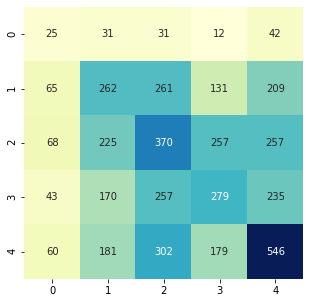

In [51]:
t_start = time.time()
sgd = SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='constant',
              loss='log', penalty='l1', random_state=42)
sgd.fit(X_train_vect, y_train)
t_end = time.time()

print(cohen_kappa_score(y_test, sgd.predict(X_test_vect), weights='quadratic'))
print(f"Time = {t_end - t_start} seconds")

cm = confusion_matrix(y_test, sgd.predict(X_test_vect))

conf_matrix = pd.DataFrame(data = cm, index=range(0, 5), columns=range(0, 5))
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [50]:
sgd = grid_search_cv(SGDClassifier(), param_grid, X_train_vect_l, y_train_l)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.7s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.6s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.9s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.0s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.7s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   1.6s
[CV 7/10] END class_weight=balanced

[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.3s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.2s
[CV 7/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.3s
[CV 8/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.3s
[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.3s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.1s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_ch

[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   4.6s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.9s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.9s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=1

[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.9s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   1.0s
[CV 6/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   1.1s
[CV 7/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   1.0s
[CV 8/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.9s
[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.8s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=invscaling, loss=lo

[CV 9/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.9s
[CV 10/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   2.0s
[CV 1/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   6.1s
[CV 2/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   6.1s
[CV 3/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   6.3s
[CV 4/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   6.0s
[CV 5/10] END class_weight=balanced, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_c

[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 8/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=1

[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.9s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.6s
[CV 1/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.8s
[CV 2/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 3/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.8s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, pena

[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 6/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.4s
[CV 7/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.2s
[CV 8/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.1s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=invscaling, loss=log, n_it

[CV 9/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 10/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 1/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   5.3s
[CV 2/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.9s
[CV 3/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   5.0s
[CV 4/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.9s
[CV 5/10] END class_weight=balanced, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10,

[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.6s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=

[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.5s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.4s
[CV 1/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 2/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, pena

[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.6s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.7s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.6s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.7s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   0.7s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_i

[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.5s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.5s
[CV 10/10] END class_weight=balanced, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.5s
[CV 1/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.4s
[CV 2/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.5s
[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.5s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_n

[CV 3/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.1s
[CV 4/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.1s
[CV 5/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.2s
[CV 6/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.3s
[CV 7/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.3s
[CV 8/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   2.3s
[CV 9/10] END class_weight=balanced, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_ch

[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   2.2s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   2.3s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.0s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.2s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.2s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   1.1s
[CV 5/10] END class_weight=None, eta0=0.01, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l2, random

[CV 6/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.5s
[CV 7/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.5s
[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.5s
[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.2s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   3.5s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=42; total time=   0.8s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=optimal, loss=log, n_iter_no_change=15, penalty=l2, random_state=

[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 5/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.7s
[CV 6/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 7/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   0.6s
[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=invscaling, loss=log, n_iter_no_change=15, penal

[CV 8/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.7s
[CV 9/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.9s
[CV 10/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   1.9s
[CV 1/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   5.7s
[CV 2/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   5.8s
[CV 3/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random_state=42; total time=   5.7s
[CV 4/10] END class_weight=None, eta0=0.01, learning_rate=adaptive, loss=log, n_iter_no_change=15, penalty=l1, random

[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.4s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=constant, loss=log, n_iter_no_change=15, penalty=l1, random_state=

[CV 2/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 3/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 4/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.6s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; tota

[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.7s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   0.9s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 2/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 3/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 4/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2, random_state=42; total time=   0.5s
[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=invscaling, loss=log, n_iter_no_change=10, penalty=l2,

[CV 5/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   6.1s
[CV 6/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   5.3s
[CV 7/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.4s
[CV 8/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   5.1s
[CV 9/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.2s
[CV 10/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   4.3s
[CV 1/10] END class_weight=None, eta0=0.1, learning_rate=adaptive, loss=log, n_iter_no_change=10, penalty=l2, random_state=

[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   2.0s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.7s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.9s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.7s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   2.0s
[CV 7/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   1.7s
[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=constant, loss=log, n_iter_no_change=10, penalty=l1, random_

[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 9/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.5s
[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.4s
[CV 1/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.2s
[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   3.3s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42; total time=   2.9s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=optimal, loss=log, n_iter_no_change=10, penalty=l1, random_state=42;

[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 7/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 8/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 9/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   0.2s
[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=invscaling, loss=log, n_iter_no_change=5, penalty=l2,

[CV 10/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l1, random_state=42; total time=   2.7s
[CV 1/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.2s
[CV 2/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.1s
[CV 3/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.3s
[CV 4/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 5/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=42; total time=   1.0s
[CV 6/10] END class_weight=None, eta0=0.05, learning_rate=adaptive, loss=log, n_iter_no_change=5, penalty=l2, random_state=

0.1615664793128454
Time = 3.1864776611328125 seconds


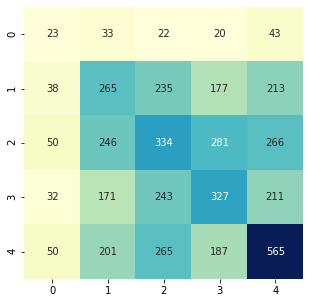

In [52]:
t_start = time.time()
sgd = SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='adaptive',
              loss='log', n_iter_no_change=15, random_state=42)
sgd.fit(X_train_vect_l, y_train_l)
t_end = time.time()

print(cohen_kappa_score(y_test_l, sgd.predict(X_test_vect_l), weights='quadratic'))
print(f"Time = {t_end - t_start} seconds")

cm = confusion_matrix(y_test_l, sgd.predict(X_test_vect_l))

conf_matrix = pd.DataFrame(data = cm, index=range(0, 5), columns=range(0, 5))
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [32]:
lst_feat = tf_vectorizer.get_feature_names()
lst_feat[lst_feat.index('25')] = 'twenty five'

In [18]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=25):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

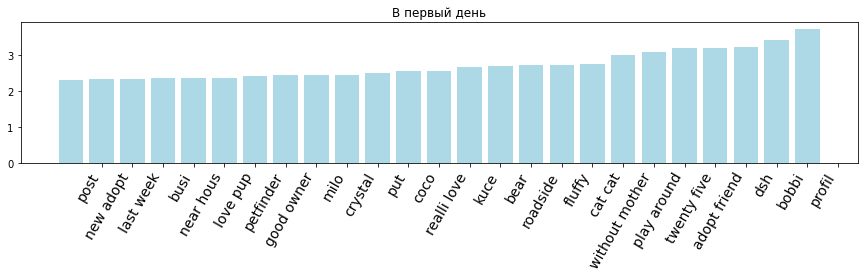

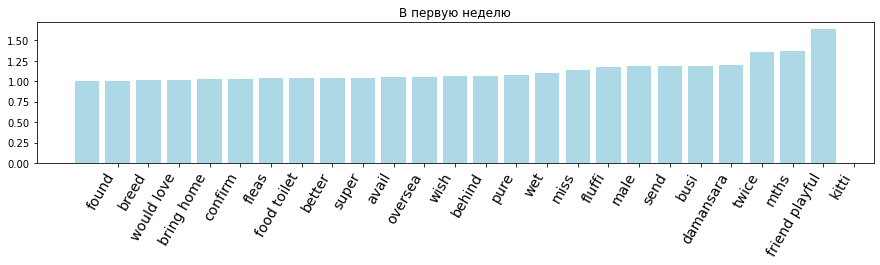

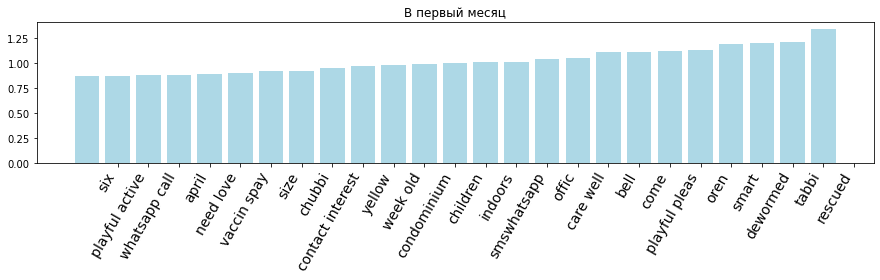

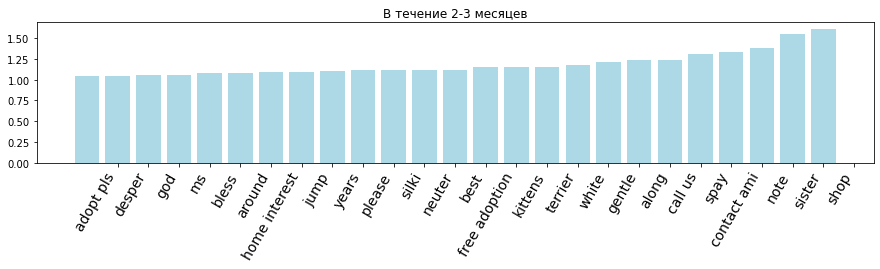

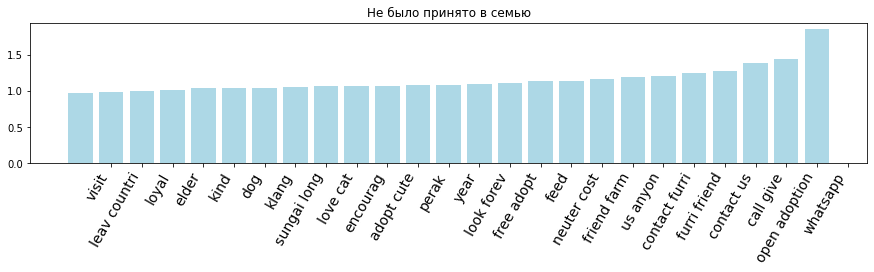

In [35]:
titles = ["В первый день", "В первую неделю", 'В первый месяц', 'В течение 2-3 месяцев', 'Не было принято в семью']
for i in range(5):
    visualize_coefficients(sgd.coef_[i,:], lst_feat,
                      title=titles[i], plot_num=i)

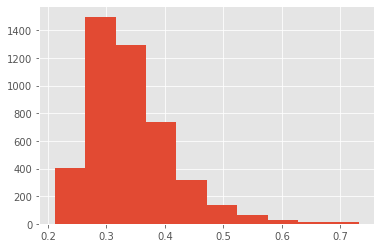

In [38]:
plt.style.use("ggplot")
plt.hist(np.max(sgd.predict_proba(X_test_tfidf), axis=1), bins=10);